In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [31]:
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from imblearn.over_sampling import SMOTE

In [32]:
plt.rcParams["figure.figsize"] = (8,6)

In [33]:
data = pd.read_csv('../ASIA_CCS_Data/Clusters/All_5_Clustering_Algo_Result_10-30-2024.csv')
data.head()

,Landing_Page_Size_In_KB,Same Landing Domain,Has Bank Related Keywords,Has Crypto Related Keywords,Has Card Related Keywords,Unique_Internal_Page_Link_Cnt,Unique_External_Page_Link_Cnt,Avg_External_Links_Len,Stdv_External_Links_Len,Ratio_Shortened_URL_And_External_Links,...,KMedoids Label,Hierarchical Label,DBSCAN Label,GMM Label,Majority Voting Label,IPQS_Flag,Domain,TLD,Searched_URL,Status Code
0,86.53,1,0,0,0,7,5,50.80,10.26,0.0,...,0,0,0,0,0,0,1001minutesforukraine.com,com,https://www.1001minutesforukraine.com,200
1,123.73,1,0,0,0,15,2,75.50,32.50,0.0,...,0,0,0,0,0,0,1to1ukrainemuseums.org,org,https://www.1to1ukrainemuseums.org,200
2,96.91,1,0,0,0,2,3,43.00,5.10,0.0,...,0,0,0,0,0,0,1violettepourlukraine.fr,fr,https://www.1violettepourlukraine.fr,200
3,1170.81,1,0,0,0,1,14,45.43,24.74,0.0,...,0,0,0,0,0,0,33lettersforukraine.com,com,https://www.33lettersforukraine.com,-1
4,47.44,1,0,0,0,25,19,29.11,17.09,0.0,...,2,2,0,2,2,1,4myukraine.com,com,https://www.4myukraine.com,200


In [34]:
print(len(data[data['Majority Voting Label'] == 1]))
print(len(data[data['Majority Voting Label'] == 0]))

print('-'*20)

print(len(data[data['IPQS_Flag'] == 1]))
print(len(data[data['IPQS_Flag'] == 0]))

print('-'*20)

print(len(data[(data['IPQS_Flag'] == 1) & (data['Majority Voting Label'] == 1)]))
print(len(data[(data['IPQS_Flag'] == 0) & (data['Majority Voting Label'] == 0)]))

388
1149
--------------------
510
1608
--------------------
262
1016


In [35]:
ipqs_ben_index = [i for i in range(len(list(data.IPQS_Flag))) if list(data.IPQS_Flag)[i]==0]
ipqs_mal_index = [i for i in range(len(list(data.IPQS_Flag))) if list(data.IPQS_Flag)[i]==1]

print(ipqs_ben_index)
print(ipqs_mal_index)
print(len(ipqs_ben_index))
print(len(ipqs_mal_index))

[0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 137, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 175, 176, 177, 178, 179, 180, 181, 184, 185, 186, 188, 189, 192, 194, 195, 196, 197, 199, 200, 201, 203, 204, 205, 206, 207, 209, 212, 213, 214, 215, 217, 218, 219, 220, 221, 222, 223, 226, 227, 228, 229, 230, 231, 232, 234, 236, 237, 238, 240, 241, 242, 243, 245, 246, 247, 249, 250, 251, 253, 254, 255, 256, 257, 258, 259, 260, 262, 263, 264, 266,

In [36]:
df = data.drop(columns=['IPQS_Flag'], axis=1)

In [37]:
print(len(data))
print(len(df))

2118
2118


In [38]:
clf_df = df.select_dtypes(include='number')
clf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2118 entries, 0 to 2117
Data columns (total 35 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Landing_Page_Size_In_KB                      2118 non-null   float64
 1   Same Landing Domain                          2118 non-null   int64  
 2   Has Bank Related Keywords                    2118 non-null   int64  
 3   Has Crypto Related Keywords                  2118 non-null   int64  
 4   Has Card Related Keywords                    2118 non-null   int64  
 5   Unique_Internal_Page_Link_Cnt                2118 non-null   int64  
 6   Unique_External_Page_Link_Cnt                2118 non-null   int64  
 7   Avg_External_Links_Len                       2118 non-null   float64
 8   Stdv_External_Links_Len                      2118 non-null   float64
 9   Ratio_Shortened_URL_And_External_Links       2118 non-null   float64
 10  

In [39]:
clf_df = clf_df.drop(columns=['Status Code'], axis=1)

In [40]:
X = np.array(normalize(clf_df[clf_df.columns[:-6]]))
Y = np.array(clf_df['Majority Voting Label'])
set(Y)

{0, 1, 2}

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.175, random_state=0, shuffle=True)

In [42]:
clf = xgb.XGBClassifier(objective='multi:softprob', max_depth=2, random_state=40, n_estimators=200, learning_rate=0.25, min_child_weight=3, gamma=0.05, colsample_bytree=0.1)
clf.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.05, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [43]:
predicted = clf.predict(x_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       187
           1       0.97      1.00      0.99        70
           2       0.99      0.97      0.98       114

    accuracy                           0.99       371
   macro avg       0.98      0.99      0.99       371
weighted avg       0.99      0.99      0.99       371



In [44]:
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, predicted, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, predicted, average='weighted')
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_test, predicted, average='weighted')
print("F1 score:", f1)

Accuracy: 0.9865229110512129
Precision: 0.9866245240234459
Recall: 0.9865229110512129
F1 score: 0.9865131681725013


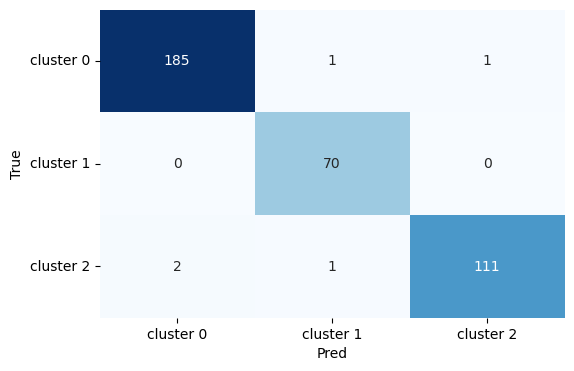

In [45]:
xgb_cm = metrics.confusion_matrix(y_test, predicted)
unique_classes = ['cluster 0', 'cluster 1', 'cluster 2']
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(xgb_cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=unique_classes,
       yticklabels=unique_classes)
plt.yticks(rotation=0)
plt.show()

In [46]:
explainer = shap.TreeExplainer(clf,X)
shap_values = explainer(X,Y)
shap_values.feature_names = clf_df.columns[:-5]

print(shap_values.shape)

[16:46:17] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 94%|=================== | 5993/6354 [00:12<00:00]       

(2118, 28, 3)


In [47]:
image_size = (6,4)

In [48]:
# shap.plots.bar(shap_values[:,:,0], max_display=10)
# shap.plots.bar(shap_values[:,:,1], max_display=10)
# shap.plots.bar(shap_values[:,:,2], max_display=10)

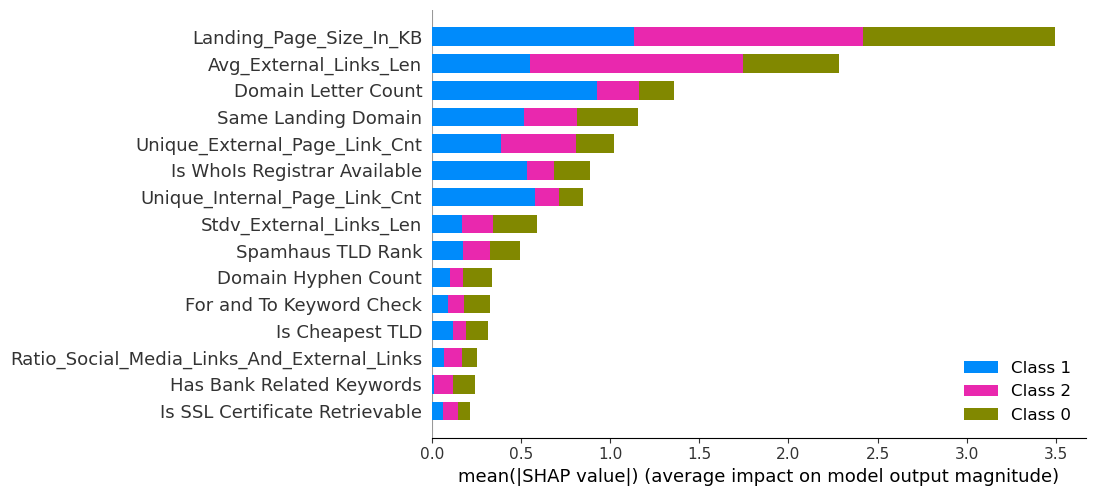

In [116]:
# plt.figure(figsize=image_size)

shap.summary_plot(
    [shap_values[:, :, class_ind].values for class_ind in range(shap_values.shape[-1])],
    feature_names=clf_df.columns[:-6],
    plot_type="bar",
    plot_size=[11,5],
    max_display=15,
    show=False
)


plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


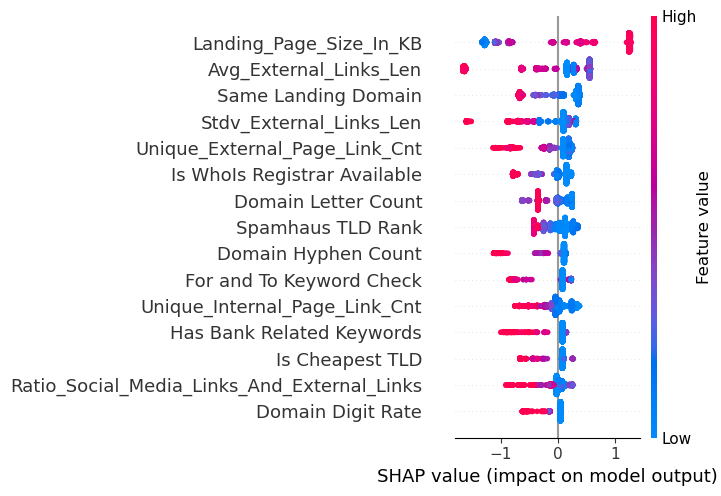

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


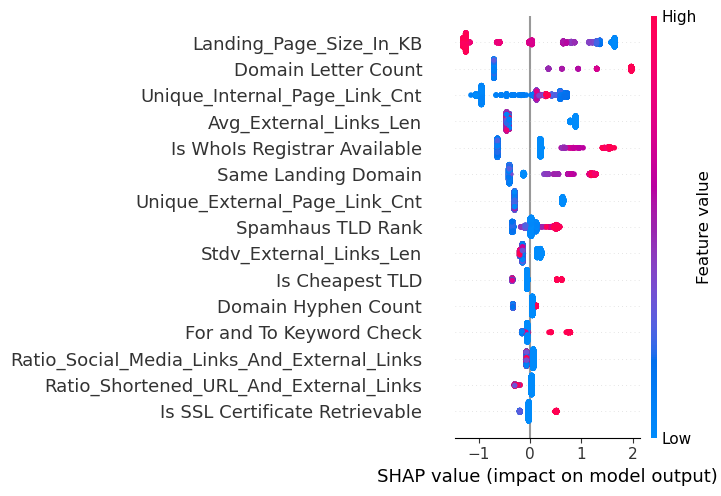

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


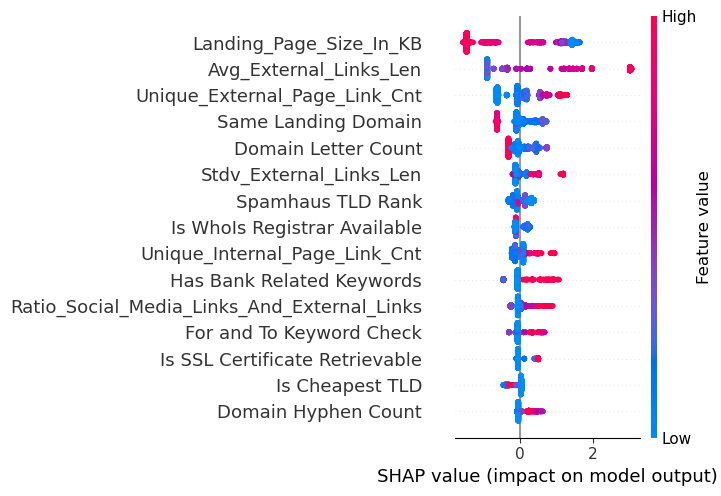

In [121]:
shap.summary_plot(shap_values[:,:,0], max_display=15,plot_size=[7,5])
shap.summary_plot(shap_values[:,:,1], max_display=15,plot_size=[7,5])
shap.summary_plot(shap_values[:,:,2], max_display=15,plot_size=[7,5])

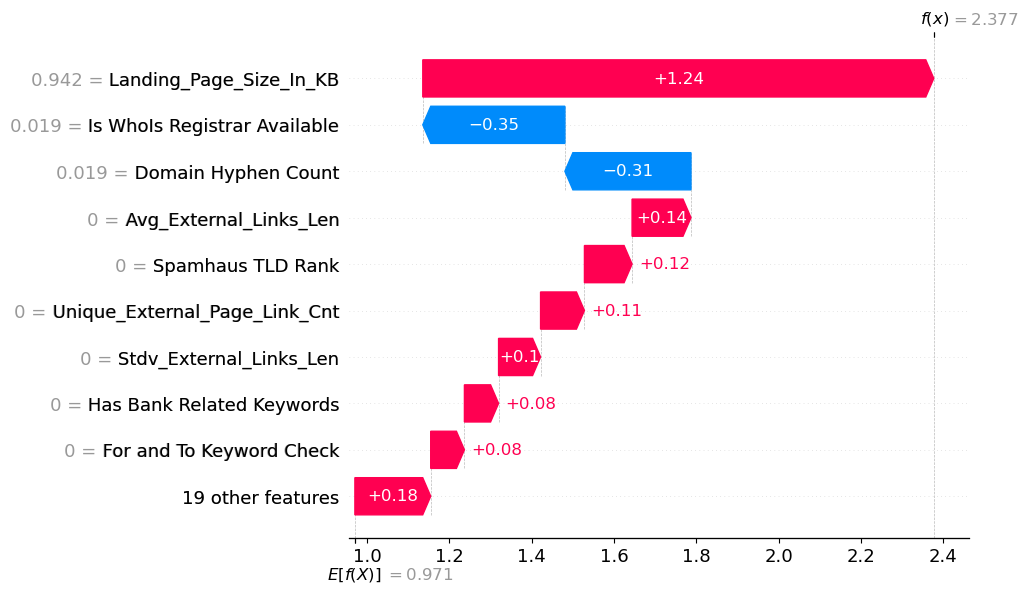

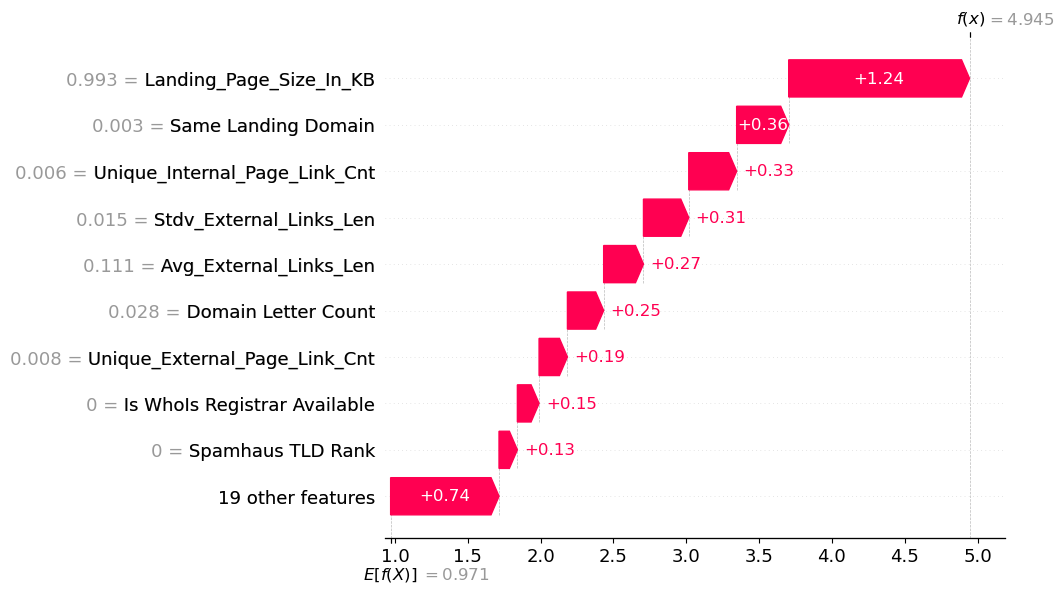

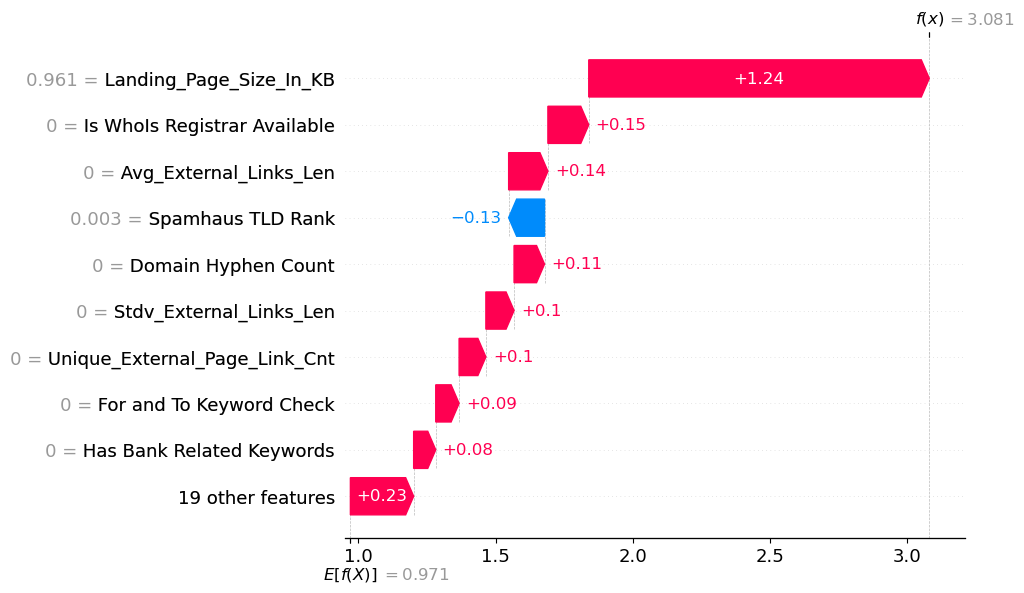

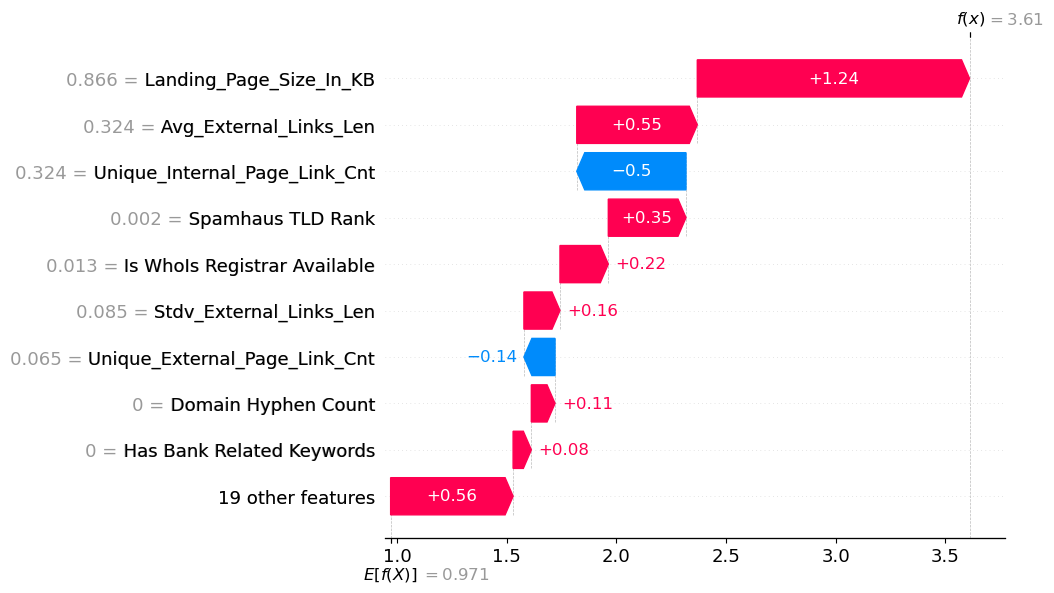

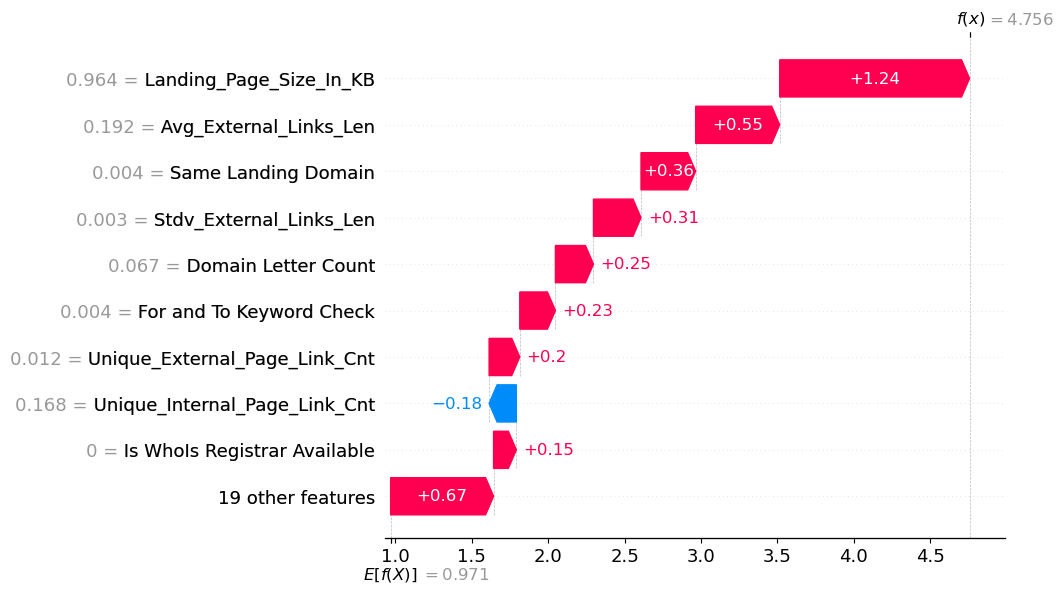

In [123]:
#local explanation for the benign class or cluster_0
cnt = 0
for i in range(1000):
    randi = np.random.randint(0,len(Y)-1)
    if Y[randi] == 0:
        cnt += 1
        fig, ax = plt.subplots(figsize=(8, 5))
        shap.plots.waterfall(shap_values[randi,:,0], max_display=10, show=False)
    
    if cnt>=5:
        break

plt.show()

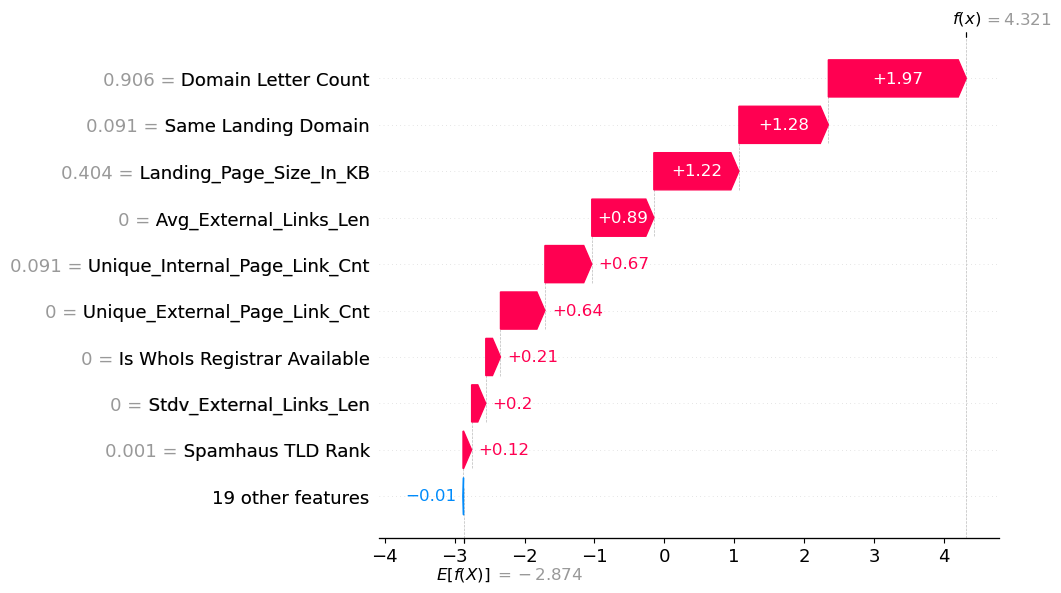

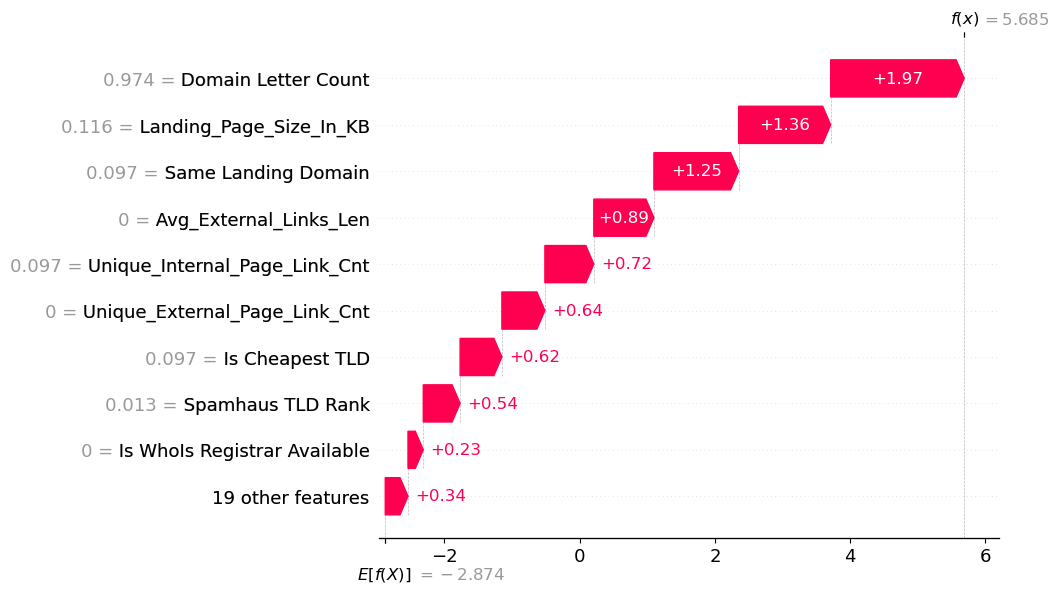

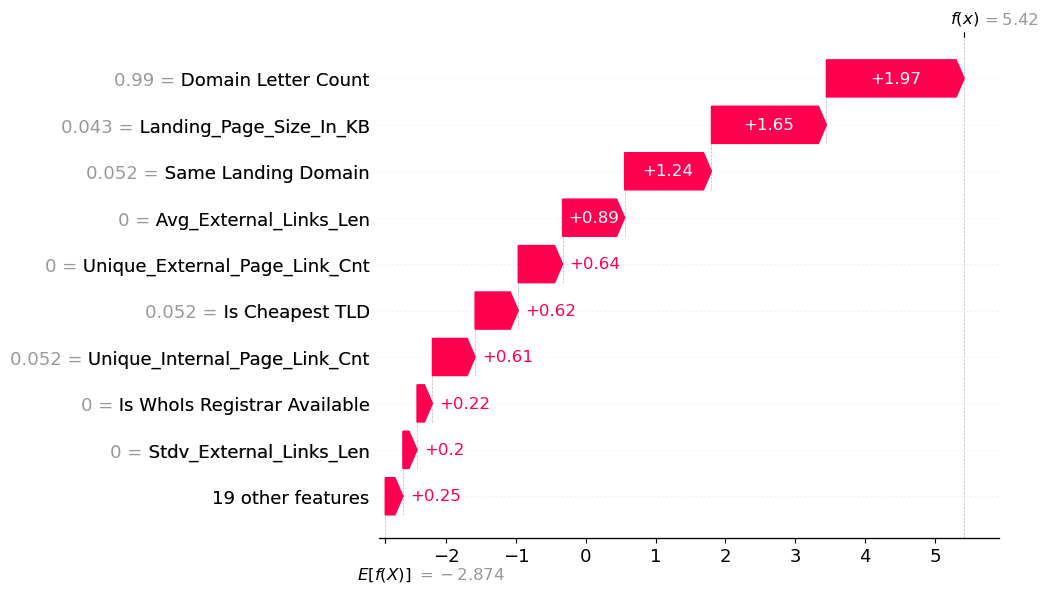

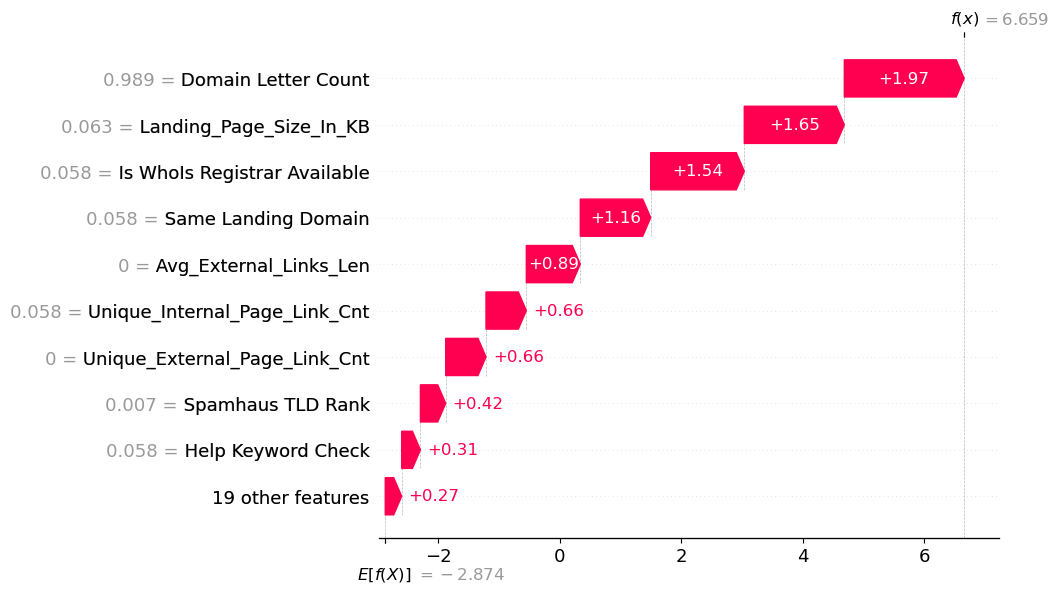

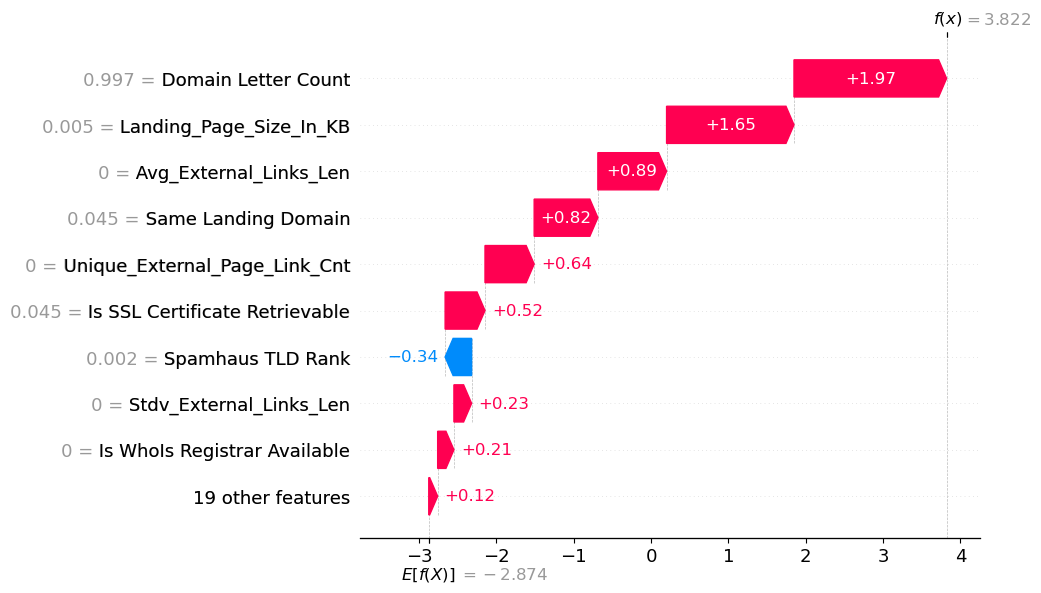

In [52]:
#local explanation for the benign class or cluster_1
cnt = 0
for i in range(1000):
    randi = np.random.randint(0,len(Y)-1)
    if Y[randi] == 1:
        cnt += 1
        plt.figure(figsize=image_size)
        shap.plots.waterfall(shap_values[randi,:,1], max_display=10)
        plt.show()
    if cnt>=5:
        break

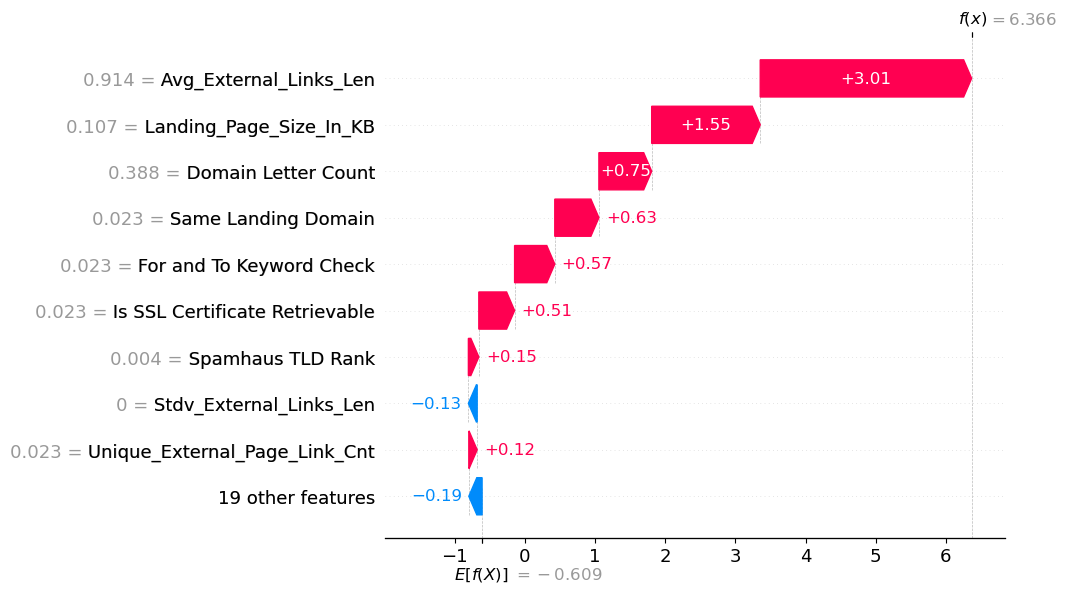

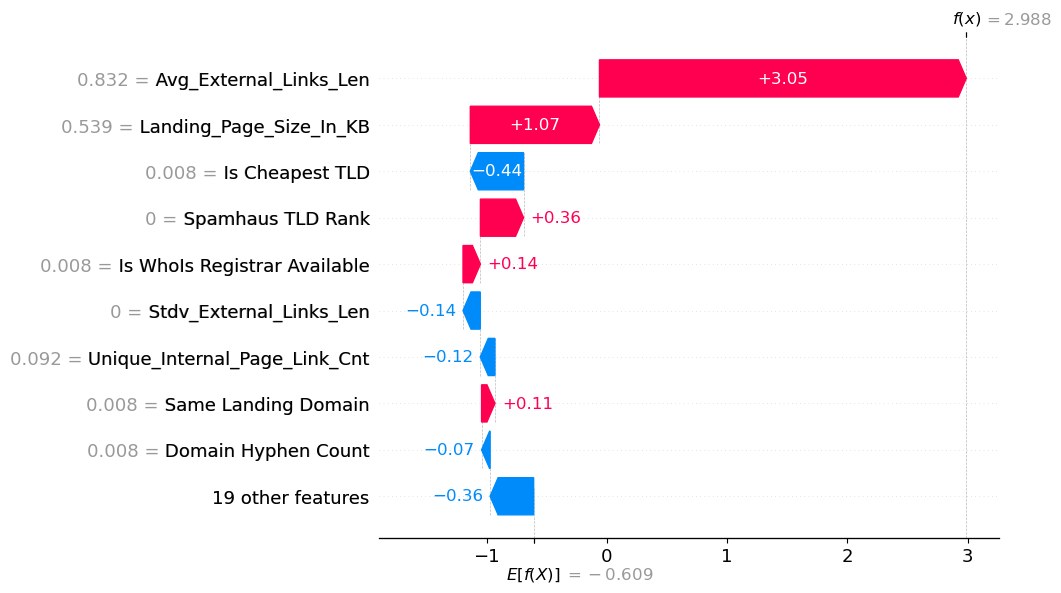

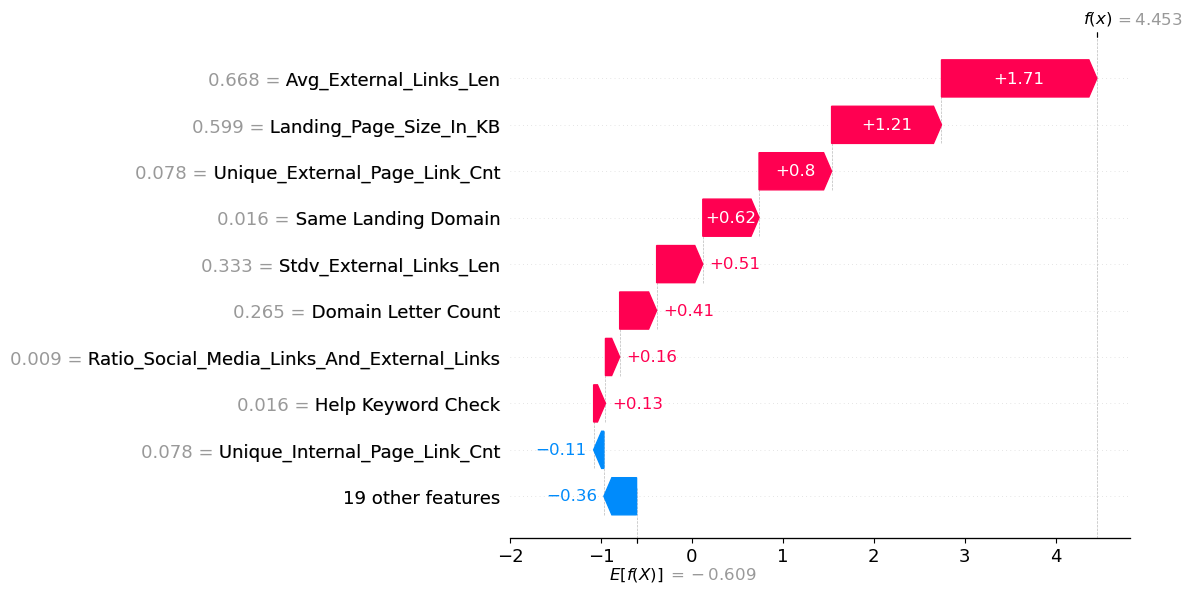

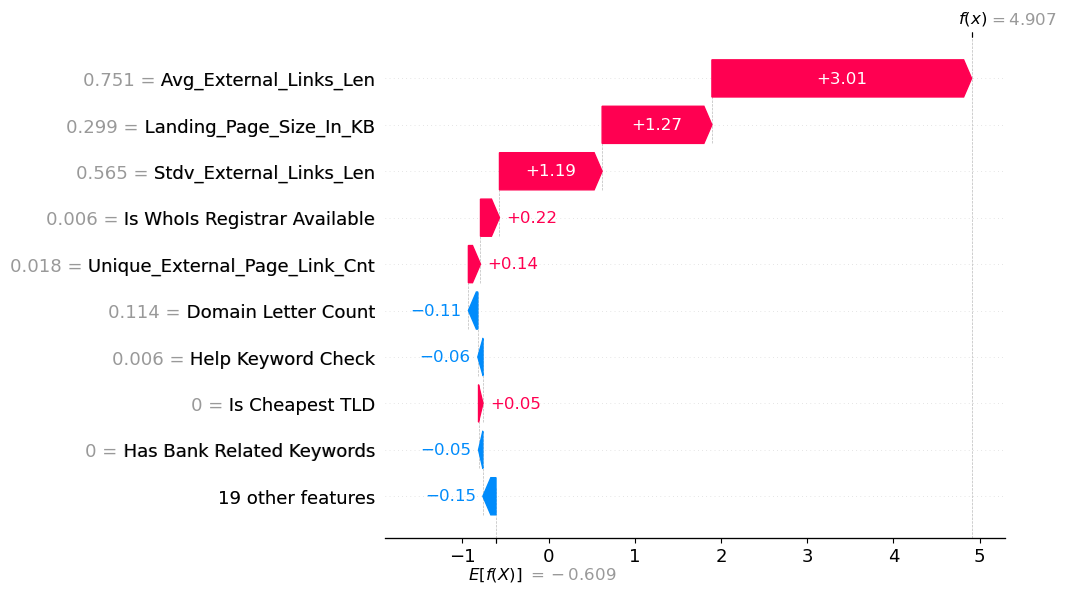

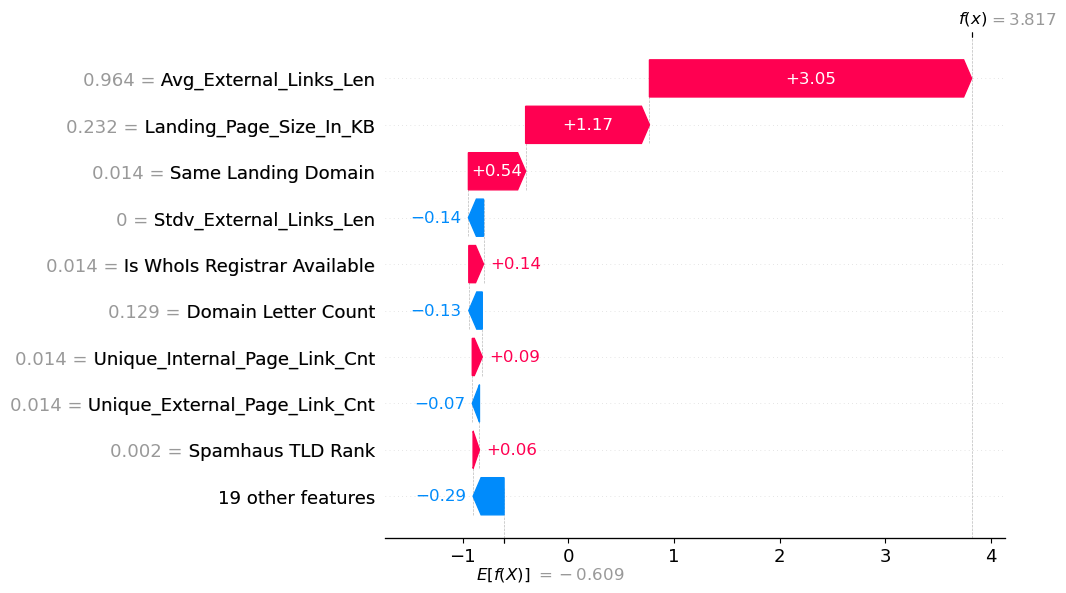

In [53]:
#local explanation for the benign class or cluster_2
cnt = 0
for i in range(1000):
    randi = np.random.randint(0,len(Y)-1)
    if Y[randi] == 2:
        cnt += 1
        plt.figure(figsize=image_size)
        shap.plots.waterfall(shap_values[randi,:,2], max_display=10)
        plt.show()
    if cnt>=5:
        break

In [54]:
print(list(Y[ipqs_ben_index]).count(0))
print(list(Y[ipqs_mal_index]).count(1))
print(list(Y[ipqs_mal_index]).count(2))

1016
262
115


cluster label by our approach 2


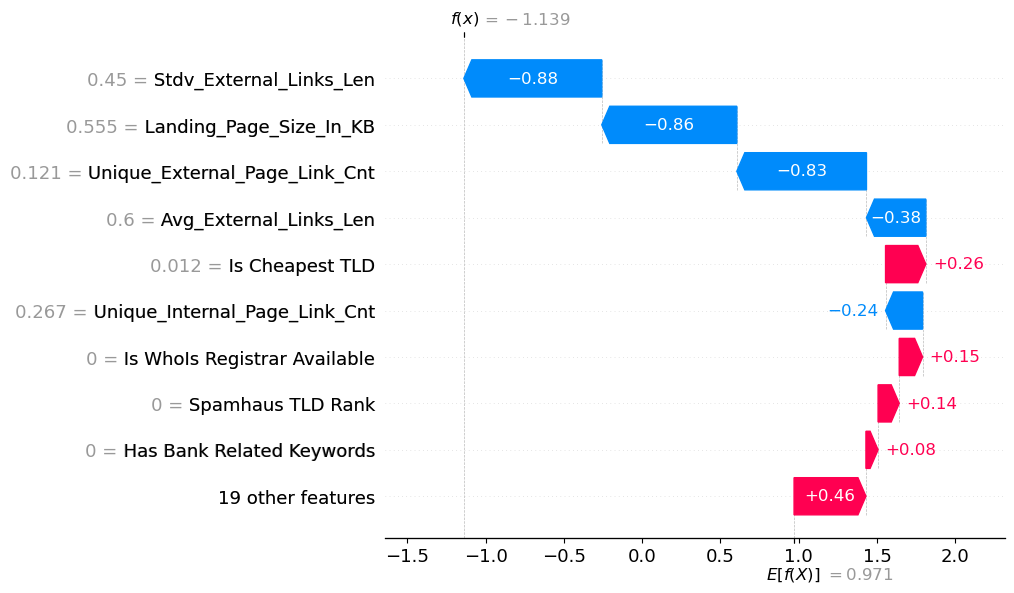

cluster label by our approach 0


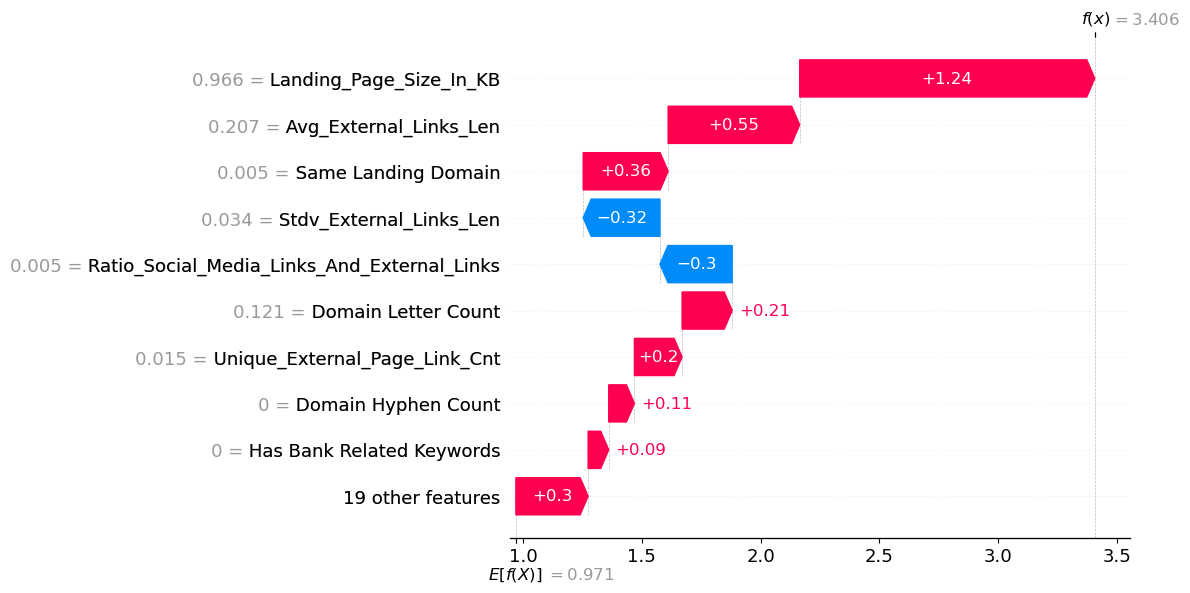

cluster label by our approach 2


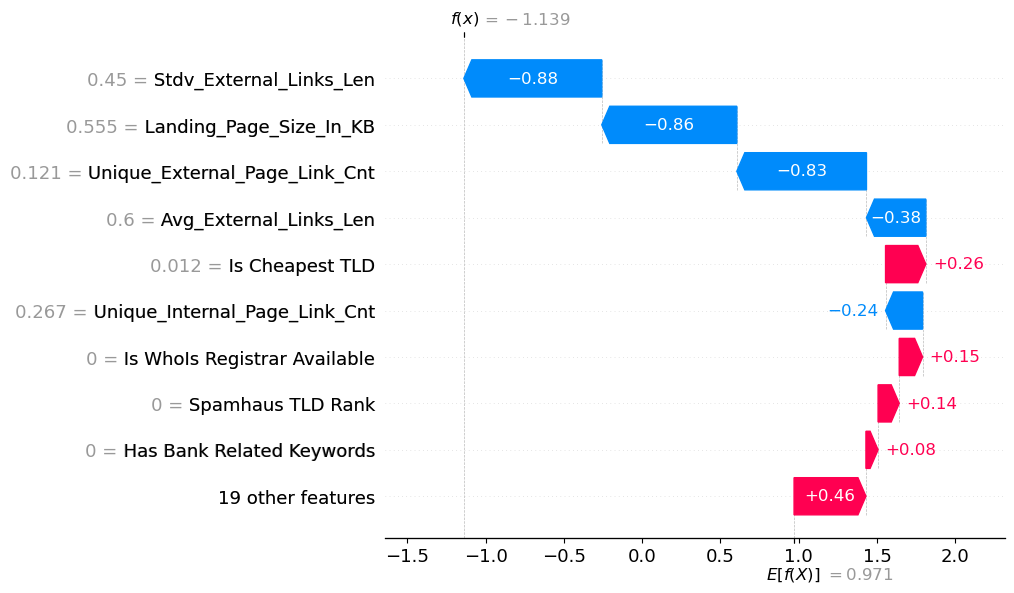

cluster label by our approach 2


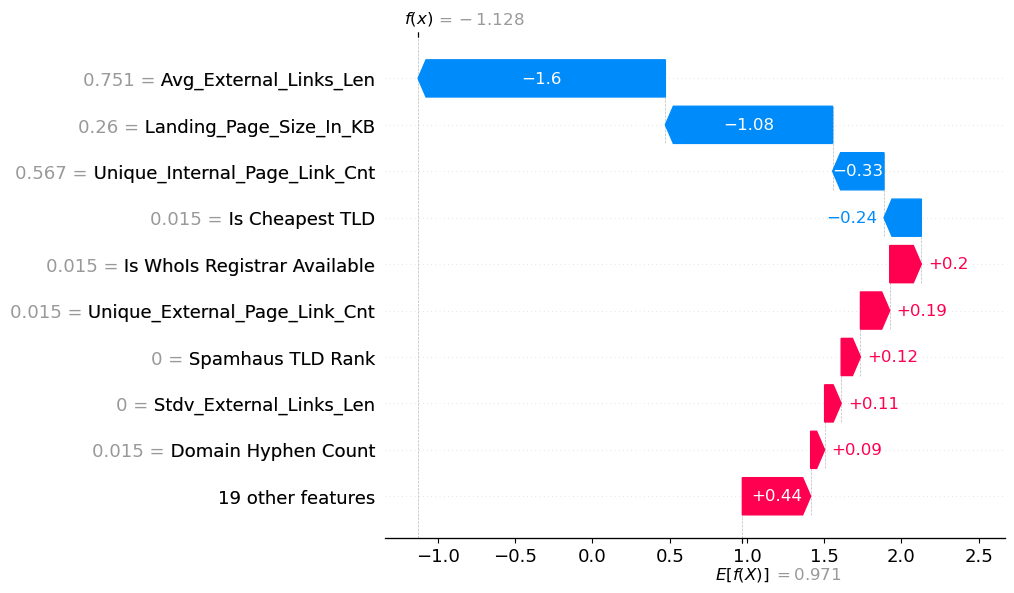

cluster label by our approach 1


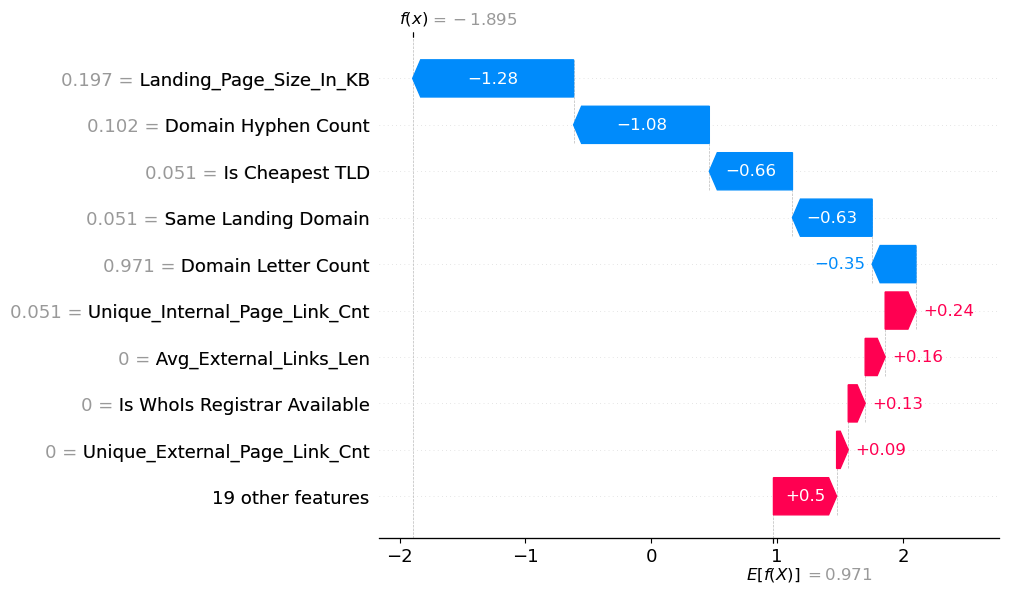

In [55]:
#local explanation for the ipqs benign class or suspicious flag false and risk score<75

for i in range(5):
    randi = random.choice(ipqs_ben_index)
    print('cluster label by our approach',Y[randi])
    shap.plots.waterfall(shap_values[randi,:,0], max_display=10, show=True)

cluster label by our approach 1


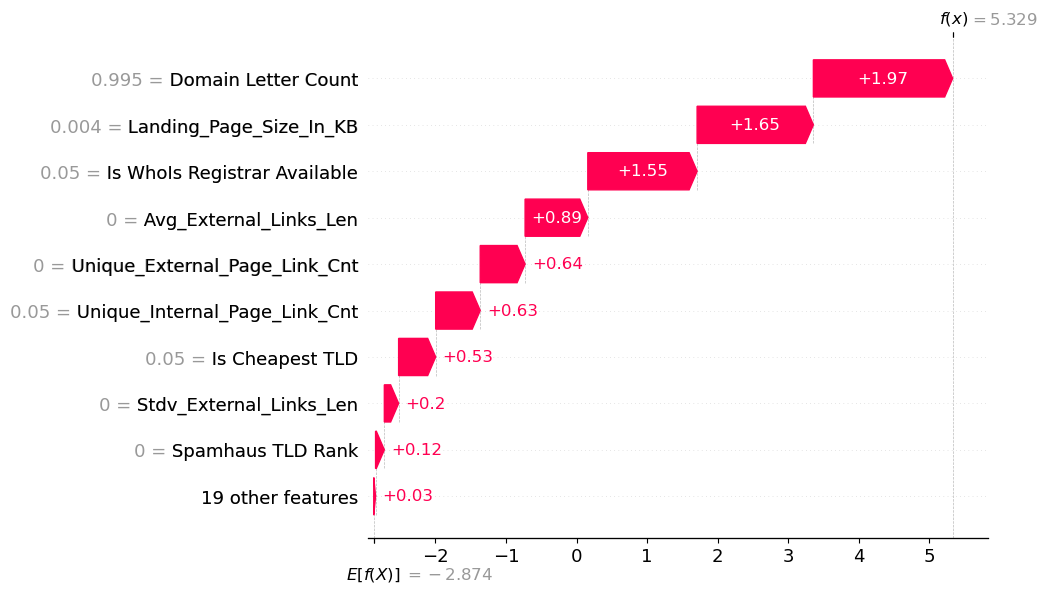

cluster label by our approach 2


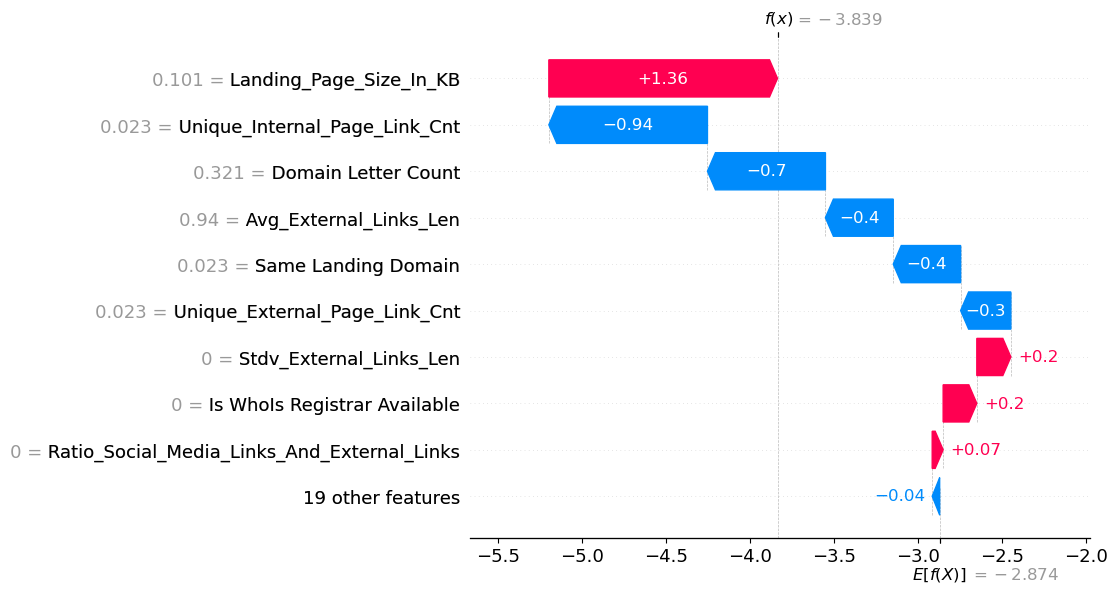

cluster label by our approach 2


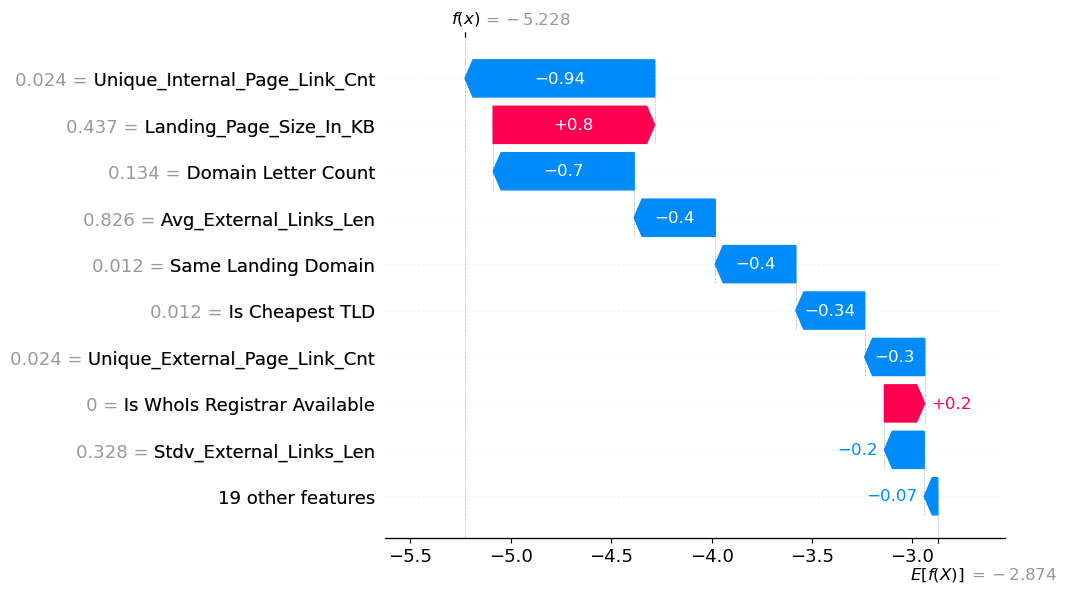

cluster label by our approach 0


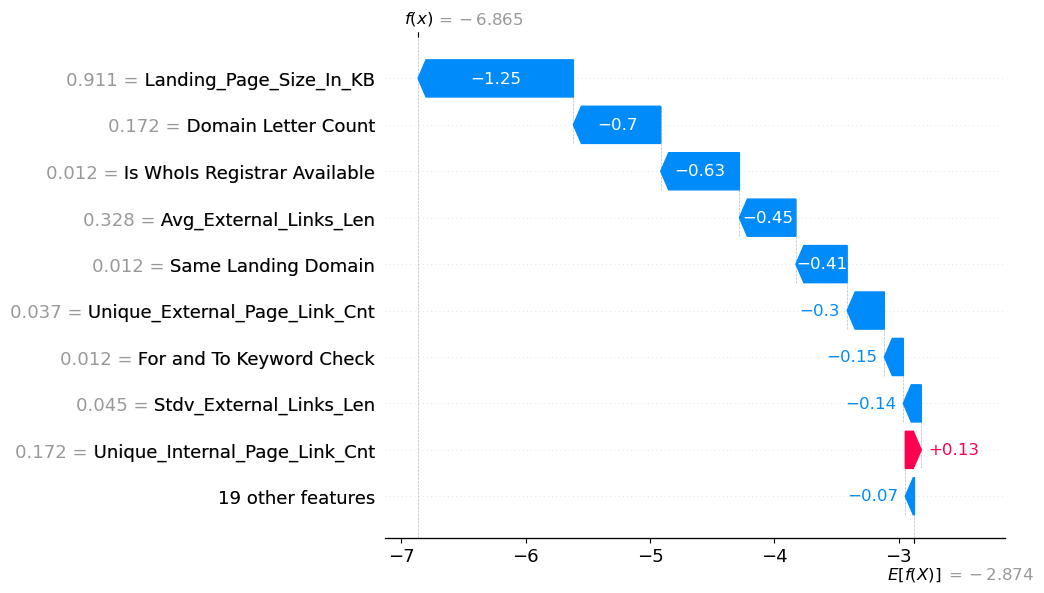

cluster label by our approach 2


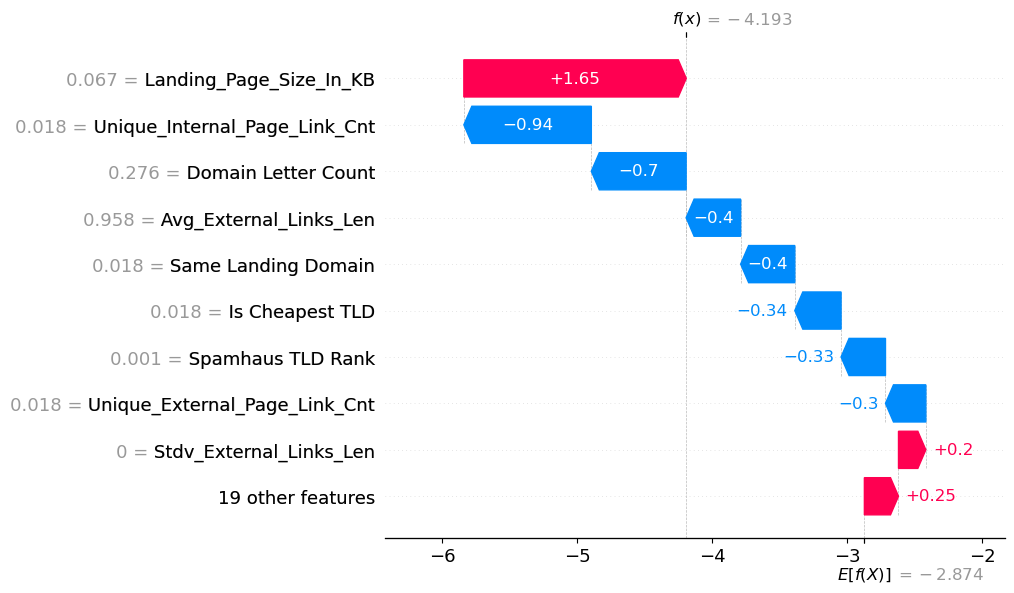

In [56]:
#local explanation for the ipqs malicious class or suspicious flag true and risk score>74

for i in range(5):
    randi = random.choice(ipqs_mal_index)
    print('cluster label by our approach',Y[randi])
    shap.plots.waterfall(shap_values[randi,:,1], max_display=10, show=True)